# COMP4030 - Data Science and Machine Learning - Coursework 2

Firstly we ensure that the raw data provided by Phyphox is unzipped and ready for import.

In [1]:
import os

def get_gestures():
      return ['circle', 'come', 'go', 'wave']

def get_columns():
    return ['time', 'accel_x', 'accel_y', 'accel_z', 'accel_abs']

def get_gesture_csvs(gesture):
      gesture_dir = os.path.join(os.getcwd(), "data", gesture)
      return [file for file in os.listdir(gesture_dir) if file.endswith('.csv')]

Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. We also use this opportunity to normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1. This will ensure that no single field plays a more important role than it should.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

## Simple function to read a csv file and return a dataframe - If scaler is provided, it will scale the data
def get_df(path, scaler=None, trim=True):
      if not path.endswith('.csv'):
            return []
      
      raw_data = pd.read_csv(path)
      raw_data.columns = get_columns()

      df = pd.DataFrame(scaler.fit_transform(raw_data) if scaler else raw_data, columns=raw_data.columns)

      return trim_recording(df) if trim else df

## Function to trim the recording to the first and last significant movement
def trim_recording(df, padding=90):
      window_size = 20
      threshold = 0.3

      df['rolling_max'] = df['accel_abs'].rolling(window=window_size, min_periods=1).mean()

      start_cut = df[df['rolling_max'] >= threshold].index.min()
      if pd.notna(start_cut):
            cut_index = max(start_cut - padding, 0)
            df = df.loc[cut_index:]
      
      end_cut = df[df['rolling_max'] >= threshold].index.max()
      if pd.notna(end_cut):
            end_cut_index = min(end_cut + padding, len(df) - 1) 
            df = df.loc[:end_cut_index]

      df = df.drop('rolling_max', axis=1)
      return df

## Function to get all the data from the files in the data folder
def get_data_from_files(scaler=None):
      dfs = []
      for gesture in get_gestures():
            for file_index, file_name in enumerate(get_gesture_csvs(gesture)):
                  df = get_df(f'data/{gesture}/{file_name}', scaler)
                  if len(df) == 0:
                        continue

                  df['file_number'] = int(file_index)
                  df['file_name'] = str(file_name)
                  df['gesture'] = str(gesture)

                  dfs.append(df)

      return pd.concat(dfs, ignore_index=True) if len(dfs) > 1 else dfs[0]

# scaler = StandardScaler()
scaler = MinMaxScaler()

df = get_data_from_files(scaler)
test_data = get_df(f'data/test/come/1.csv', scaler)
df

,time,accel_x,accel_y,accel_z,accel_abs,file_number,file_name,gesture
0,0.048098,0.535730,0.548018,0.229814,0.039610,0,1.csv,circle
1,0.048815,0.549592,0.545577,0.203769,0.057488,0,1.csv,circle
2,0.049533,0.547687,0.562679,0.216363,0.045317,0,1.csv,circle
3,0.050251,0.548894,0.566675,0.239260,0.048563,0,1.csv,circle
4,0.050969,0.548961,0.573507,0.237559,0.049097,0,1.csv,circle
...,...,...,...,...,...,...,...,...
26461,0.983442,0.516840,0.898125,0.596165,0.009438,9,wave5.csv,wave
26462,0.984033,0.517999,0.902521,0.597518,0.007391,9,wave5.csv,wave
26463,0.984624,0.520665,0.905240,0.598694,0.005232,9,wave5.csv,wave
26464,0.985216,0.523374,0.909225,0.600580,0.006959,9,wave5.csv,wave


Next we apply a low-pass filter to reduce noise from the data and make our model more robust

In [3]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [4]:
# Filter parameters
cutoff_frequency = 4  # Cutoff frequency in Hz - Higher = less smoothing
sampling_rate = 50  # Sampling rate in Hz - Higher = more smoothing
filter_order = 10  # Filter order - Higher = less smoothing

for column in get_columns()[1:]:
    df[column] = butter_lowpass_filter(df[column], cutoff_frequency, sampling_rate, filter_order)

Next we visualise our raw data for exploratory analysis

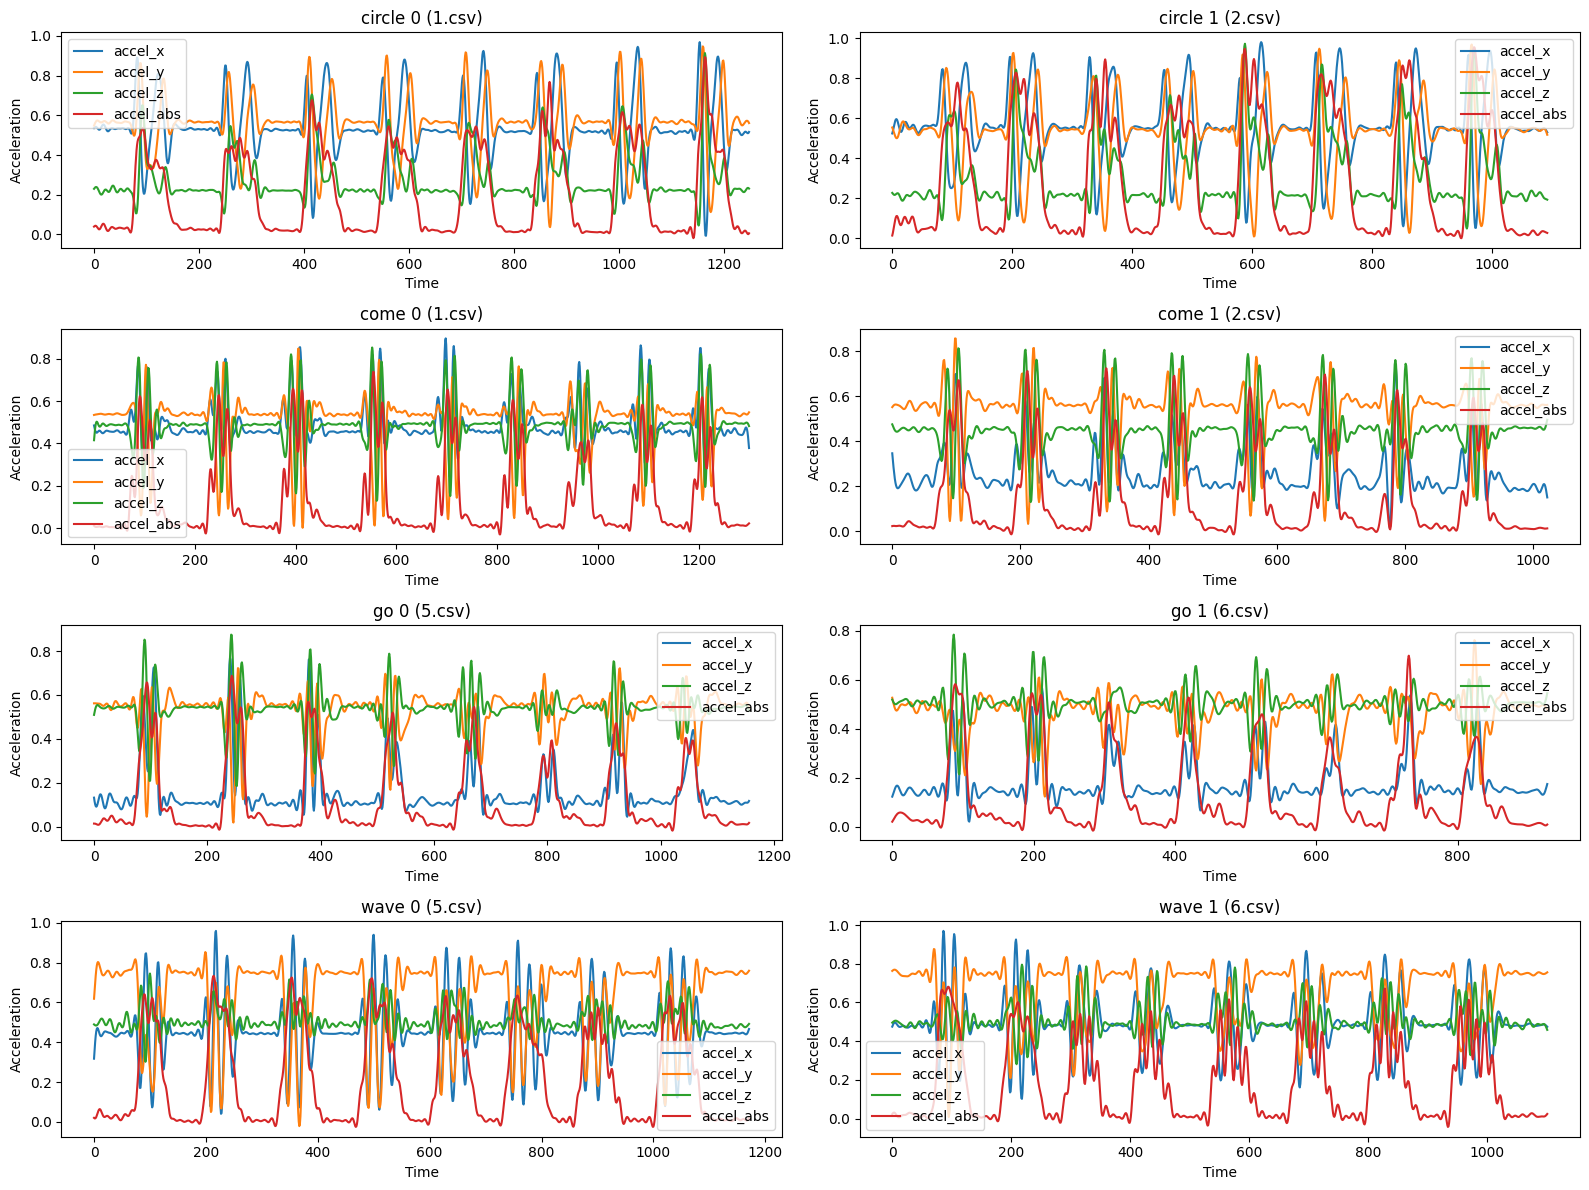

In [5]:
import matplotlib.pyplot as plt

gestures = df['gesture'].unique()
file_numbers = df['file_number'].unique()[:2]

fig, axs = plt.subplots(4, 2, figsize=(16, 12))

for i, file_number in enumerate(file_numbers):
    for j, gesture in enumerate(gestures):
        data = df[(df['gesture'] == gesture) & (df['file_number'] == file_number)].reset_index(drop=True)
        
        ax = axs[j, i]
        for col in get_columns()[1:]:
            ax.plot(data.index, data[col], label=col)
            ax.set_title("{gesture} {file_number} ({file_name})".format(gesture=gesture, file_number=file_number, file_name=data['file_name'][0]))
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')
            ax.legend()
        
plt.tight_layout()
plt.show()

We then try to segment this data, using the dips in acceleration that we had purposefully included in our data captures.

Firstly we visualise just one example to inspect the rolling standard deviation and attempt to find the optimal parameters for slicing our data.

In [6]:
rolling_window = 25
group_threshold = 10
deviation_threshold = 2.5

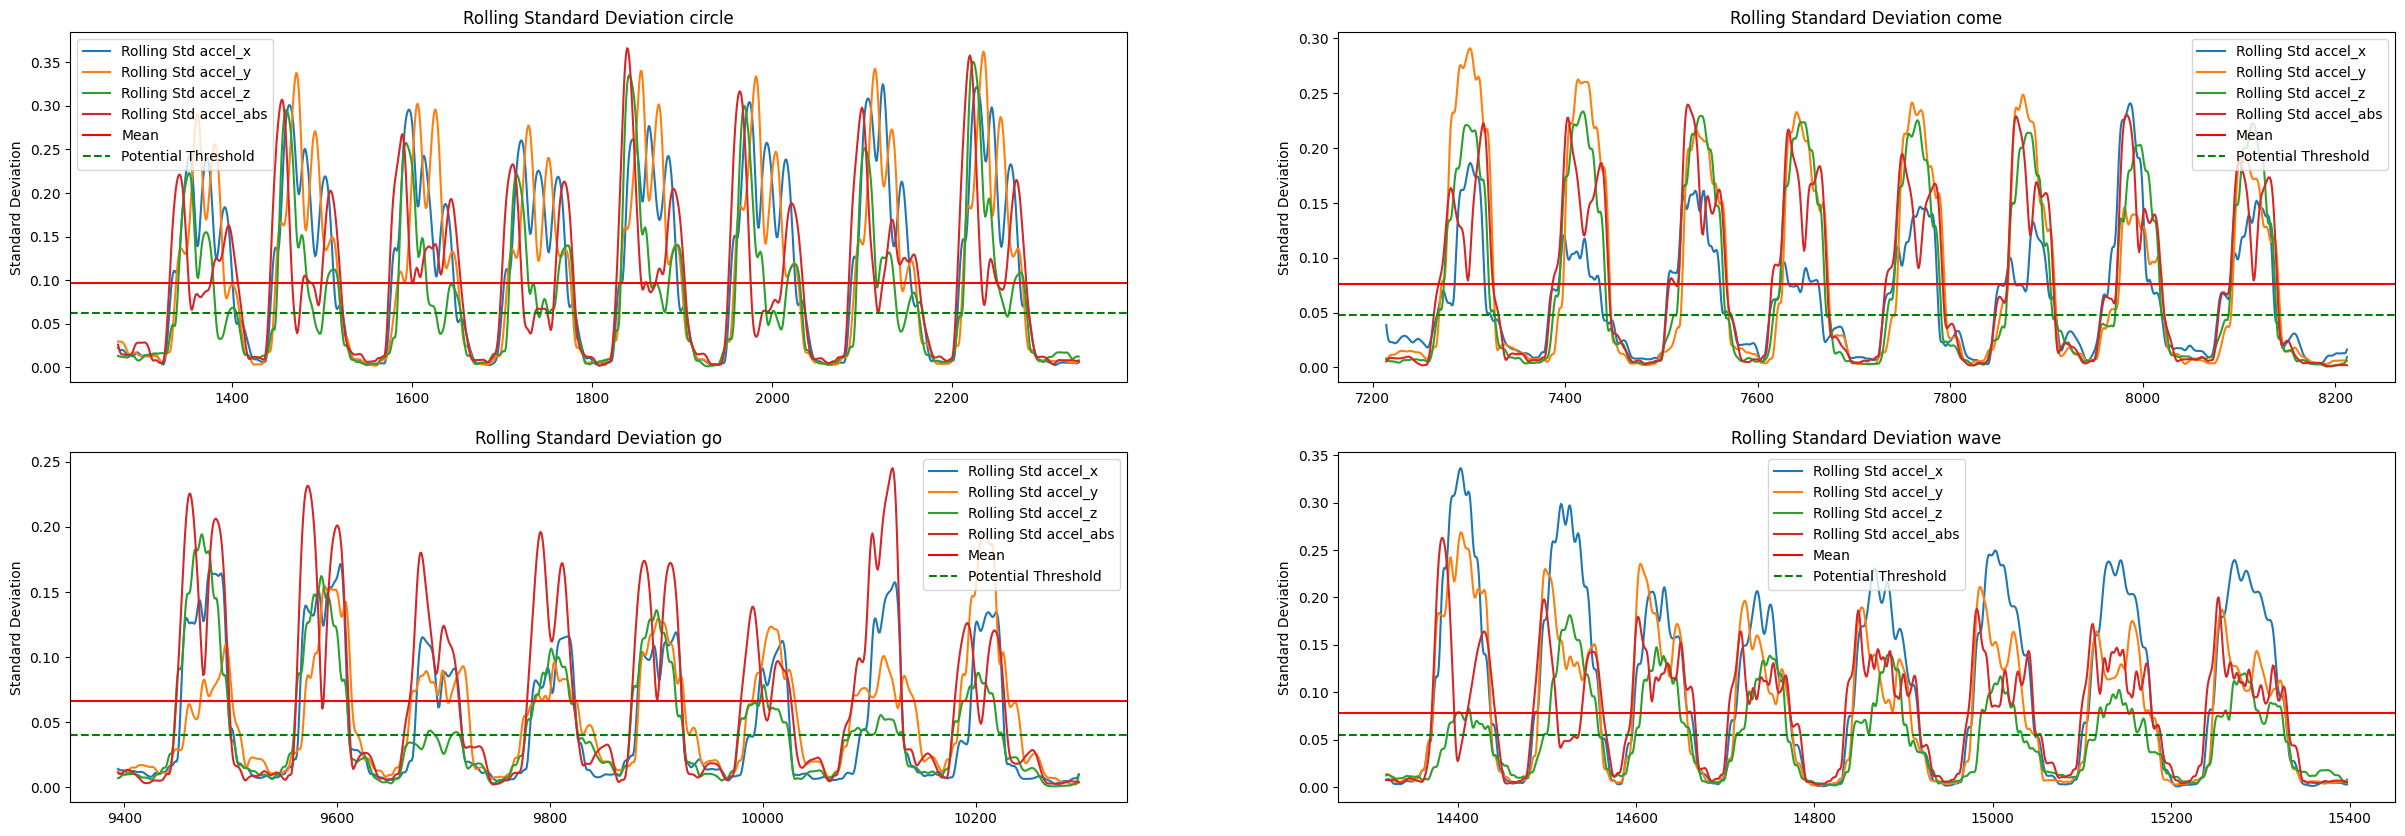

In [7]:
plt.figure(figsize=(30, 10))

for file_index, gesture in enumerate(get_gestures()):

      group = df[(df['gesture'] == gesture) & (df['file_number'] == 1)]
      if len(group) == 0:
            continue

      rolling_std = group['accel_abs'].rolling(window=rolling_window).std()
      drop_all_below = rolling_std.mean() - rolling_std.std() / deviation_threshold

      plt.subplot(2, 2, file_index + 1)

      for col in get_columns()[1:]:
            plt.plot(group[col].rolling(window=rolling_window).std(), label=f'Rolling Std {col}')

      plt.axhline(y=rolling_std.mean(), color='r', linestyle='-', label='Mean')
      plt.axhline(y=drop_all_below, color='g', linestyle='--', label='Potential Threshold')    
      plt.title(f'Rolling Standard Deviation {gesture}')
      plt.ylabel('Standard Deviation')
      plt.legend()

plt.show()

In [8]:
## Function to get the indices of the data points that are below the threshold
def get_indices_below_threshold(data, rolling_window, group_threshold, deviation_threshold):
      
      rolling_std = data['accel_abs'].rolling(window=rolling_window).std()
      threshold = rolling_std.mean() - rolling_std.std() / deviation_threshold

      return rolling_std[(rolling_std.shift(-group_threshold) < threshold) & (rolling_std.shift(group_threshold) < threshold)].index

## This function will merge the indices that are close to each other and return the average of the points
def cluster_and_average_points(integers, cluster_range=50):
      if(len(integers) == 0):
            return []
            
      clusters = []
      current_cluster = [integers[0]]

      for number in integers[1:]:
            if number - current_cluster[-1] <= cluster_range:
                  current_cluster.append(number)
            else:
                  clusters.append(current_cluster)
                  current_cluster = [number]
      
      if current_cluster:
            clusters.append(current_cluster)
      
      return [sum(cluster) // len(cluster) for cluster in clusters]

Then we visualise our slices for all of the data.

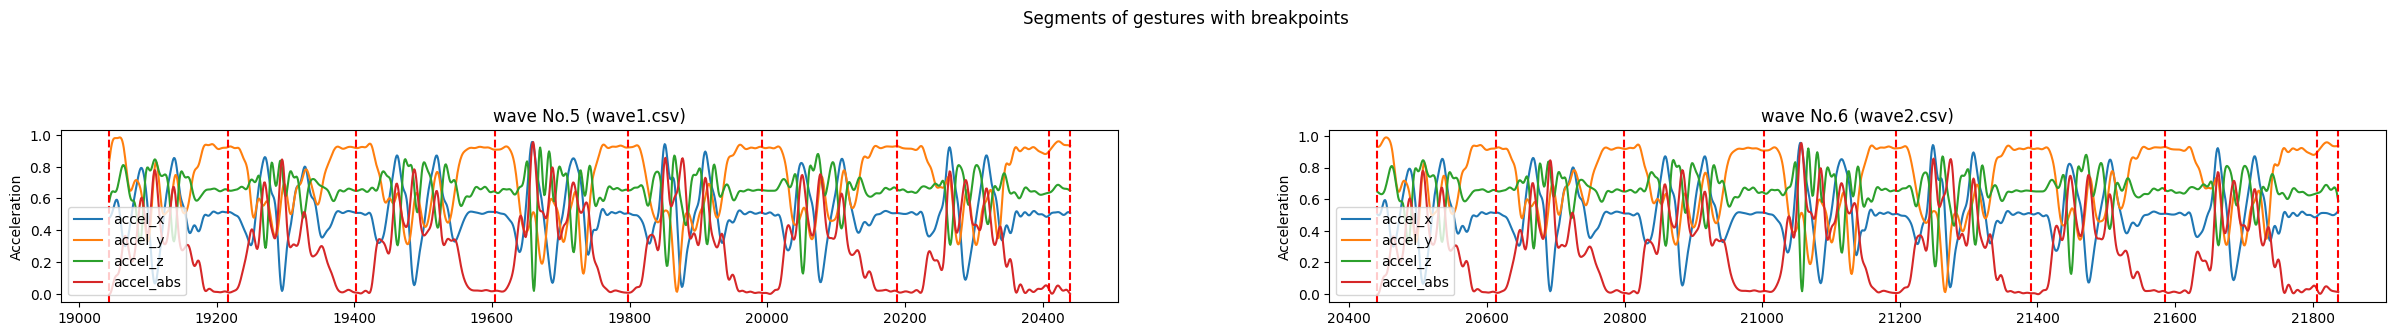

In [9]:
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for file_index, sub_group in feature.groupby('file_number'):

        indices_below_threshold = get_indices_below_threshold(sub_group, rolling_window, group_threshold, deviation_threshold)
        breakpoints = cluster_and_average_points(indices_below_threshold, 25)
        breakpoints.append(sub_group.index[-1])
        breakpoints.append(sub_group.index[0])

        if file_index < 5 or file_index > 6:
            continue

        plt.subplot(4, 2, plot)
        plot += 1

        for col in get_columns()[1:]:
            plt.plot(sub_group.index, sub_group[col], label=col)

        for index in breakpoints:
            plt.axvline(x=index, color='r', linestyle='--')

        file_name = sub_group['file_name'].iloc[0]
        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{file_index} ({file_name})')
        plt.legend()
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

We also visualise our test data splitting

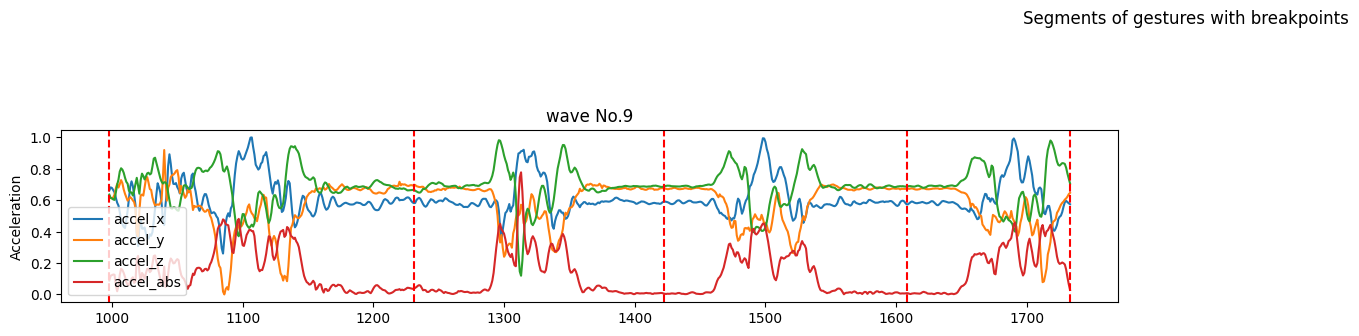

In [10]:
plt.figure(figsize=(30, 12))
plot = 1

indices_below_threshold = get_indices_below_threshold(test_data, rolling_window, group_threshold, deviation_threshold)
breakpoints = cluster_and_average_points(indices_below_threshold, 25)
breakpoints.append(test_data.index[-1])
breakpoints.append(test_data.index[0])

plt.subplot(4, 2, plot)
plot += 1

for col in get_columns()[1:]:
      plt.plot(test_data.index, test_data[col], label=col)

for index in breakpoints:
      plt.axvline(x=index, color='r', linestyle='--')

plt.ylabel('Acceleration')
plt.title(f'{gesture} No.{file_index}')
plt.legend()
plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

We can safely remove the data where the absolute acceleration never gets above a certain threshold. Then split the data into those separate waves that represent each gesture.

In [11]:
def apply_segmentation_and_geture_numbering(df, drop_all_below, short_segment_threshold):
            
      indices_to_drop = []
      gesture_number = 1

      for i, sub_group in df.groupby(['file_number', 'gesture']):

            indices_below_threshold = get_indices_below_threshold(sub_group, rolling_window, group_threshold, deviation_threshold)
            breakpoints = cluster_and_average_points(indices_below_threshold, 25)

            breakpoints.insert(0, sub_group.index[0])
            breakpoints.append(sub_group.index[-1])

            for b in range(len(breakpoints) - 1):
                  segment = df.loc[breakpoints[b]:breakpoints[b+ 1]]['accel_abs']
                  all_below_threshold = (segment < drop_all_below).all()
                  if all_below_threshold or len(segment) < short_segment_threshold:
                        dropping = range(breakpoints[b], breakpoints[b + 1])
                        indices_to_drop += dropping
                  else:
                        df.loc[breakpoints[b]:breakpoints[b + 1], 'gesture_number'] = int(gesture_number)
                        gesture_number += 1

      df.drop(indices_to_drop, inplace=True)
      df.dropna(subset=['gesture_number'], inplace=True)
      df.reset_index(drop=True, inplace=True)

In [12]:
## Apply segmentation and clearing of invalid gestures
apply_segmentation_and_geture_numbering(df, drop_all_below = 0.3, short_segment_threshold = 50)

In [13]:
## Apply segmentation and clearing of invalid gestures to TEST DATA
def apply_segmentation_and_geture_numbering_test_data(df, drop_all_below, short_segment_threshold):
            
      indices_to_drop = []
      gesture_number = 1

      indices_below_threshold = get_indices_below_threshold(df, rolling_window, group_threshold, deviation_threshold)
      breakpoints = cluster_and_average_points(indices_below_threshold, 25)

      breakpoints.insert(0, df.index[0])
      breakpoints.append(df.index[-1])

      for b in range(len(breakpoints) - 1):
            segment = df.loc[breakpoints[b]:breakpoints[b+ 1]]['accel_abs']
            all_below_threshold = (segment < drop_all_below).all()
            if all_below_threshold or len(segment) < short_segment_threshold:
                  dropping = range(breakpoints[b], breakpoints[b + 1])
                  indices_to_drop += dropping
            else:
                  df.loc[breakpoints[b]:breakpoints[b + 1], 'gesture_number'] = int(gesture_number)
                  gesture_number += 1

      df.drop(indices_to_drop, inplace=True)
      df.dropna(subset=['gesture_number'], inplace=True)
      df.reset_index(drop=True, inplace=True)

apply_segmentation_and_geture_numbering_test_data(test_data, drop_all_below = 0.3, short_segment_threshold = 50)

In [14]:
test_data

,time,accel_x,accel_y,accel_z,accel_abs,gesture_number
0,0.365430,0.662558,0.626984,0.635795,0.089144,1.0
1,0.365796,0.681854,0.614352,0.615154,0.119003,1.0
2,0.366162,0.678258,0.611676,0.611731,0.122704,1.0
3,0.366529,0.664626,0.617777,0.604919,0.126860,1.0
4,0.366895,0.650317,0.636131,0.601919,0.125311,1.0
...,...,...,...,...,...,...
731,0.633098,0.587067,0.603777,0.831024,0.190563,4.0
732,0.633464,0.596010,0.611499,0.807221,0.158958,4.0
733,0.633830,0.587898,0.622773,0.769612,0.109209,4.0
734,0.634196,0.580438,0.638440,0.736954,0.065267,4.0


In [15]:
def number_to_color(number):    
    normalized_number = (number - 1) / (100 - 1)
    colormap = plt.cm.viridis
    color = colormap(normalized_number)
    
    return color

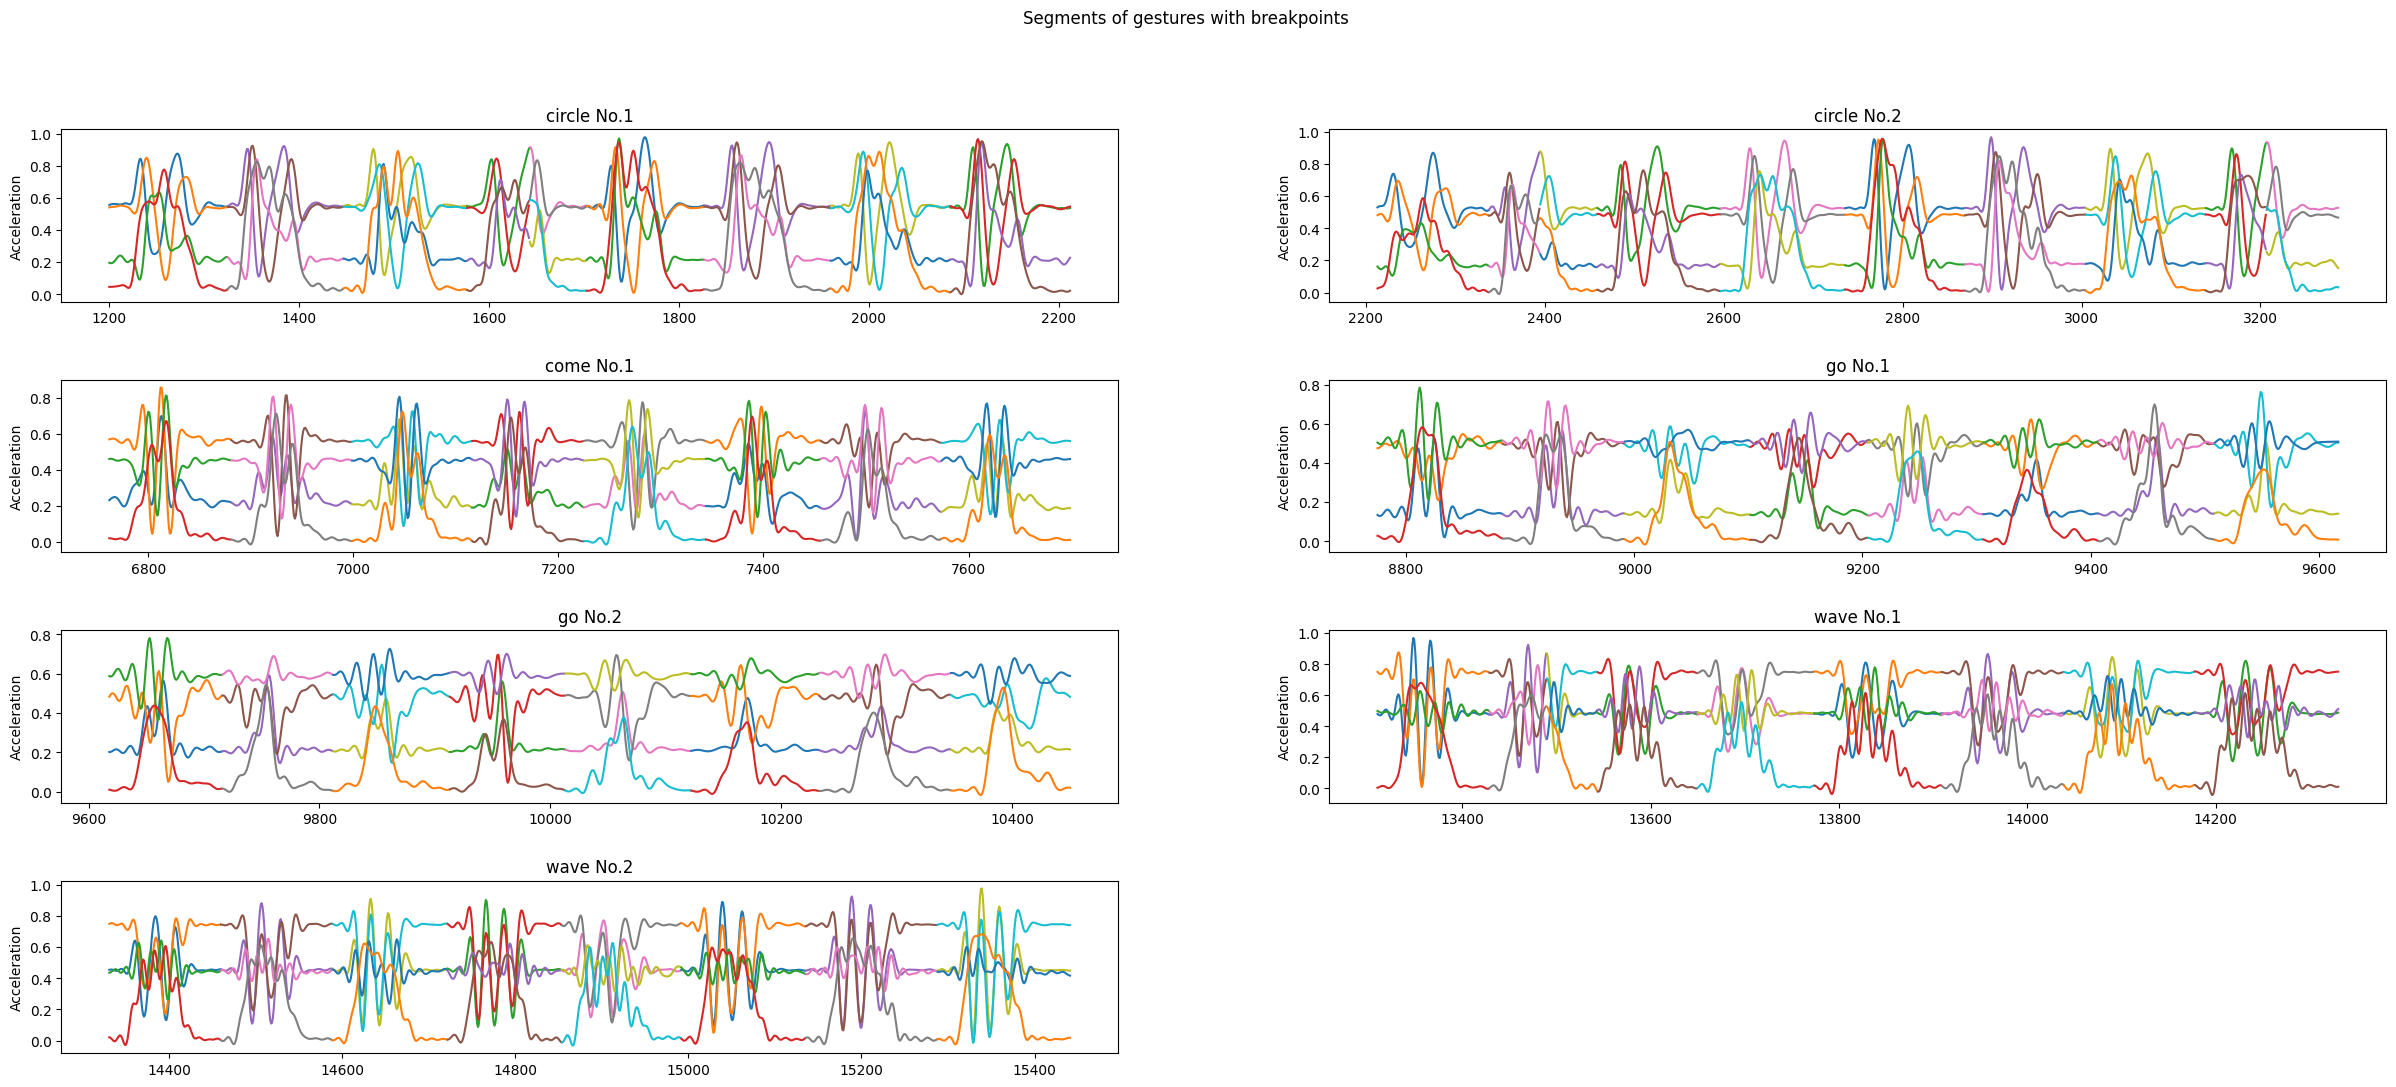

In [16]:
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for file_index, sub_group in feature.groupby('file_number'):

        if file_index < 1 or file_index > 2:
            continue

        plt.subplot(4, 2, plot)
        plot += 1

        for gesture_number in sub_group['gesture_number'].unique():
            gesture_group = sub_group[sub_group['gesture_number'] == gesture_number]        
        
            for col in get_columns()[1:]:
                plt.plot(gesture_group.index, gesture_group[col], label=number_to_color(gesture_number))

        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{file_index}')
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

Now we double check that the data does not contain these filtered out data segments that do not represent a gesture

In [17]:
## Check we no longer have segments that are very short or have very low acceleration
for label, group in df.groupby(['gesture', 'gesture_number']):
      if(group.shape[0] < 50):
            data = df[(df['gesture'] == label[0]) & (df['gesture_number'] == label[1])]
            print(label, group.shape[0], data['file_number'].unique(), data['gesture_number'].unique(), data['accel_abs'].max())

Finally we can begin to extract our features for the models. These functions split the data into a fixed number of segments with some overlap and then take some key statistical values from these slices.

In [18]:
def create_fixed_segments_df(data, num_segments, step_size):
    total_length = len(data)
    window_size = ((num_segments - 1) * step_size) + (total_length - (num_segments - 1) * step_size)

    segments = [data.iloc[i:i + window_size] for i in range(0, total_length - window_size + 1, step_size)]
    
    if len(segments) < num_segments:
        while len(segments) < num_segments and window_size > 0:
            window_size -= 1
            segments = [data.iloc[i:i + window_size] for i in range(0, total_length - window_size + 1, step_size)]
    
    return segments

def get_features_from_df(df, feature_functions, num_segments = 4, step_size = 10):
      results = []

      for _, data in df.groupby(['gesture_number']): # for each gesture in the data frame, extract features
            result_dict = {}

            if 'gesture' in data.columns:
                  result_dict['gesture'] = data['gesture'].iloc[0]
            
            segments = create_fixed_segments_df(data, num_segments, step_size)
            for n, segment in enumerate(segments):
                  for col in get_columns()[1:]:
                        for f in feature_functions:
                              result_dict[f'{col}_{f}_{n+1}'] = segment[col].agg(f)

            results.append(result_dict)

      return pd.DataFrame(results)

In [19]:
feature_functions = ['mean', 'std', 'min', 'max', 'median', 'skew', 'kurtosis']
num_segments = 4
step_size = 10

extracted_features = get_features_from_df(df, feature_functions, num_segments, step_size)
extracted_features

,gesture,accel_x_mean_1,accel_x_std_1,accel_x_min_1,accel_x_max_1,accel_x_median_1,accel_x_skew_1,accel_x_kurtosis_1,accel_y_mean_1,accel_y_std_1,...,accel_z_median_4,accel_z_skew_4,accel_z_kurtosis_4,accel_abs_mean_4,accel_abs_std_4,accel_abs_min_4,accel_abs_max_4,accel_abs_median_4,accel_abs_skew_4,accel_abs_kurtosis_4
0,circle,0.547618,0.153509,0.204750,0.891355,0.534349,0.092568,0.089770,0.555514,0.127889,...,0.223451,1.904797,3.611897,0.210824,0.181803,0.021805,0.536859,0.158281,0.306194,-1.500008
1,circle,0.575045,0.104141,0.499406,0.851312,0.530206,1.897414,2.040768,0.568034,0.043522,...,0.349592,-0.153459,-1.480846,0.336513,0.158875,0.007830,0.486980,0.411734,-1.277216,0.019360
2,circle,0.584113,0.152094,0.383827,0.869282,0.529275,0.658030,-0.868302,0.580541,0.103181,...,0.220981,-1.635133,3.154618,0.032310,0.021061,0.016772,0.107585,0.024578,2.036992,3.539241
3,circle,0.537138,0.170348,0.082958,0.863172,0.524658,-0.272936,0.670090,0.554231,0.155669,...,0.227926,1.524680,1.417544,0.248863,0.221604,0.012563,0.676246,0.189707,0.380884,-1.335113
4,circle,0.578512,0.099812,0.427045,0.790743,0.523313,1.094265,-0.196729,0.608737,0.115414,...,0.424464,-0.414891,-0.790708,0.446123,0.062861,0.273660,0.544457,0.448316,-0.718854,0.679274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,wave,0.521276,0.167117,0.185132,0.834903,0.516331,0.216531,-0.560112,0.600644,0.234007,...,0.615150,-1.380488,2.168240,0.300993,0.209704,0.001592,0.722867,0.316259,0.029026,-1.066367
182,wave,0.516027,0.172065,0.122270,0.841149,0.515134,0.150338,-0.397542,0.535551,0.256217,...,0.608705,-1.391839,1.807270,0.322336,0.206783,0.009270,0.708206,0.325999,0.054969,-0.891640
183,wave,0.523805,0.183425,0.164707,0.915667,0.518336,0.419023,-0.425912,0.516315,0.289178,...,0.595131,-0.729928,0.668984,0.341923,0.226667,0.001620,0.767388,0.383180,0.005145,-1.018226
184,wave,0.520953,0.186078,0.141687,0.951992,0.516177,0.352781,-0.362298,0.464698,0.291065,...,0.592715,-0.854747,1.885120,0.332888,0.240847,0.003413,0.839677,0.373503,-0.007147,-1.068861


In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def encode_labels(labels):
    return label_encoder.fit_transform(labels)

def decode_labels(encoded_labels):
    return label_encoder.inverse_transform(encoded_labels)

In [21]:
from sklearn.model_selection import train_test_split

labels = encode_labels(extracted_features['gesture'])
features = extracted_features.loc[:, extracted_features.columns != 'gesture']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [23]:
rfc_model.fit(features, labels)

RandomForestClassifier(random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rfc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        19

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [25]:
test_features = get_features_from_df(test_data, feature_functions, num_segments, step_size)
test_features

,accel_x_mean_1,accel_x_std_1,accel_x_min_1,accel_x_max_1,accel_x_median_1,accel_x_skew_1,accel_x_kurtosis_1,accel_y_mean_1,accel_y_std_1,accel_y_min_1,...,accel_z_median_4,accel_z_skew_4,accel_z_kurtosis_4,accel_abs_mean_4,accel_abs_std_4,accel_abs_min_4,accel_abs_max_4,accel_abs_median_4,accel_abs_skew_4,accel_abs_kurtosis_4
0,0.616831,0.143845,0.260573,1.000000,0.584631,0.425866,0.102056,0.547857,0.180050,0.000000,...,0.684393,-0.230417,0.255981,0.167644,0.145555,0.002714,0.481210,0.137300,0.625845,-0.992514
1,0.611533,0.109011,0.355442,0.921374,0.586223,1.404927,1.901807,0.587821,0.129445,0.239918,...,0.687986,-1.165144,4.556347,0.133129,0.162825,0.001928,0.777374,0.036587,1.440149,1.994197
2,0.611650,0.109432,0.455470,0.994850,0.583563,1.727413,2.822372,0.577715,0.122933,0.262104,...,0.689430,-0.624270,0.918740,0.133174,0.136548,0.000960,0.451053,0.071609,0.677541,-0.862137
3,0.639547,0.122057,0.479093,0.993442,0.587865,1.374241,0.946767,0.580112,0.098989,0.373081,...,0.702231,-0.170563,-1.085074,0.223338,0.127489,0.000707,0.458223,0.233297,-0.176514,-0.798190


In [26]:
results = rfc_model.predict(test_features)

print("Original labels:", decode_labels(results))

Original labels: ['wave' 'come' 'wave' 'wave']


In [27]:
from sklearn import svm

svm_model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [28]:
svm_y_pred = svm_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, svm_y_pred)}")
print(classification_report(y_test, svm_y_pred))

Accuracy: 0.9473684210526315
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.75      0.75      0.75         4
           2       0.80      1.00      0.89         4
           3       1.00      0.95      0.97        19

    accuracy                           0.95        38
   macro avg       0.89      0.92      0.90        38
weighted avg       0.95      0.95      0.95        38



In [29]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
 
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
rfc = RandomForestClassifier(random_state=42)
 
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
 
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
 
y_pred = best_estimator.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Best Parameters:", best_params)
print("Balanced Accuracy:", balanced_accuracy)

NameError: name 'X' is not defined

In [ ]:
from xgboost import XGBClassifier
 
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
 
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
xgb_classifier = XGBClassifier(random_state=42)
 
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
 
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='balanced_accuracy', cv=5)
grid_search.fit(X_train, y_train)
 
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
 
y_pred = best_estimator.predict(X_test)
 
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Best Parameters:", best_params)
print("Balanced Accuracy:", balanced_accuracy)